In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay)

# 1. Load Data
data_path = '../diabetic_data.csv'
df = pd.read_csv(data_path)

# 2.  Cleaning
df.replace('?', np.nan, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 3. Encoding
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# 4. Feature Scaling (REQUIRED for kNN)
X = df.drop('readmitted', axis=1)
y = df['readmitted']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Strategic Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ kNN Data Scaled and Ready.")

C:\Users\dkshp\AppData\Local\Temp\ipykernel_14412\1061324867.py:24: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:


✅ kNN Data Scaled and Ready.


In [ ]:
# 1. Initialize kNN
# weights='distance' gives closer neighbors more influence 
# metric='euclidean' is the standard distance formula
knn_model = KNeighborsClassifier(
    n_neighbors=11, 
    weights='distance', 
    n_jobs=-1 # Uses all CPU cores to speed up the distance calculations
)

# 2. "Fitting" the model
# In kNN, this is instant because it just stores the points
print("Storing training points...")
knn_model.fit(X_train, y_train)

# 3. Predicting (This is the part that takes time)
print("Calculating distances for test set... please wait.")
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

print("✅ kNN Predictions Complete.")

Storing training points...
Calculating distances for test set... please wait.
✅ kNN Predictions Complete.


======= k-NEAREST NEIGHBORS (kNN) EVALUATION =======
Accuracy Score: 0.5854
Area Under Curve (AUC): 0.6118

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63     10468
           1       0.56      0.49      0.53      9143

    accuracy                           0.59     19611
   macro avg       0.58      0.58      0.58     19611
weighted avg       0.58      0.59      0.58     19611



C:\Users\dkshp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


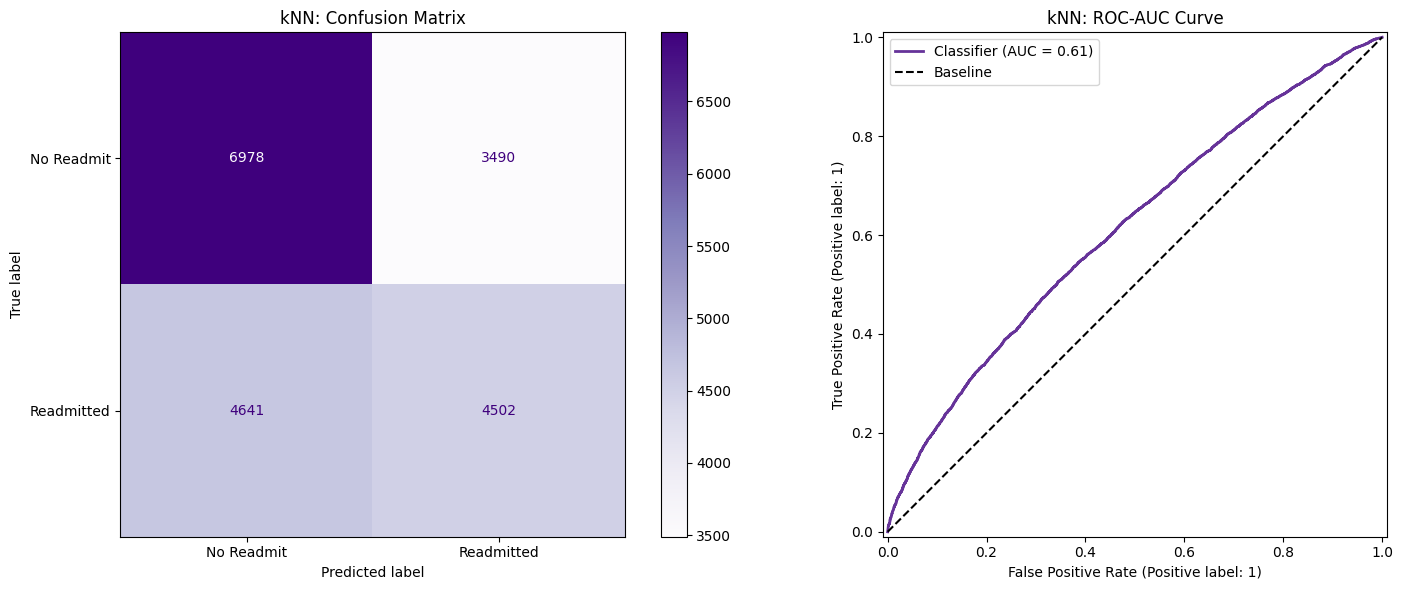

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 1. Detailed Statistical Report
print("======= k-NEAREST NEIGHBORS (kNN) EVALUATION =======")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Area Under Curve (AUC): {roc_auc_score(y_test, y_prob_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# 2. Visual Dashboard
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_knn, 
    display_labels=['No Readmit', 'Readmitted'],
    cmap='Purples',
    ax=ax1
)
ax1.set_title('kNN: Confusion Matrix')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, 
    y_prob_knn, 
    ax=ax2,
    color='rebeccapurple',
    linewidth=2
)
ax2.plot([0, 1], [0, 1], 'k--', label='Baseline')
ax2.set_title('kNN: ROC-AUC Curve')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os
from sklearn.metrics import precision_recall_fscore_support

# 1. Extract Metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn, average=None)

current_model_name = "kNN"
results_path = '../overall_results.csv'

# 2. Prepare the Row
new_result = pd.DataFrame({
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred_knn)],
    'Recall_C1': [recall[1]], 
    'F1_Score': [f1[1]]
})

# 3. Update CSV
if not os.path.isfile(results_path):
    new_result.to_csv(results_path, index=False)
else:
    df_existing = pd.read_csv(results_path)
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    pd.concat([df_existing, new_result], ignore_index=True).to_csv(results_path, index=False)

print(f"✅ Success! {current_model_name} metrics added to the leaderboard.")

✅ Success! kNN metrics added to the leaderboard.
